# Анализ и выявление мошеннических транзакций

**Цель проекта:** Провести комплексный анализ данных о финансовых транзакциях для выявления паттернов мошенничества, проверить продуктовые и технические гипотезы, а также построить базовую модель машинного обучения для классификации операций.

**Используемые технологии:** Polars для высокопроизводительной обработки данных, Scikit-learn и LightGBM для построения ML-модели, Plotly и Seaborn для визуализации.

## Этап 1: Подготовка среды и загрузка данных

In [1]:
# Импорт необходимых библиотек
import polars as pl
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import warnings

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    precision_recall_curve,
    auc,
    confusion_matrix,
    ConfusionMatrixDisplay
)
import lightgbm as lgb

# Настройки для лучшего отображения и игнорирования предупреждений
pl.Config.set_tbl_rows(10)
pl.Config.set_tbl_cols(20)
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
warnings.filterwarnings('ignore')

print("Библиотеки и настройки успешно применены.")
print(f"Polars version: {pl.__version__}")

Библиотеки и настройки успешно применены.
Polars version: 1.32.2


In [2]:
# Загрузка данных из parquet-файлов
try:
    df_transactions = pl.read_parquet('transaction_fraud_data.parquet')
    df_exchange = pl.read_parquet('historical_currency_exchange.parquet')
    print("Файлы успешно загружены.")
except Exception as e:
    print(f"Ошибка при загрузке файлов: {e}")
    # Прерываем выполнение, если файлы не найдены
    exit()

# Первичный осмотр данных
print(f"\nРазмер основного датасета: {df_transactions.shape}")
print(f"Размер датасета с курсами валют: {df_exchange.shape}")

print("\nСтруктура основного датасета:")
df_transactions.glimpse()

# Проверка на пропущенные значения и дубликаты
print(f"\nКоличество пропущенных значений в каждом столбце:\n{df_transactions.null_count()}")
n_duplicates = df_transactions['transaction_id'].is_duplicated().sum()
print(f"\nКоличество дубликатов по transaction_id: {n_duplicates}")

Файлы успешно загружены.

Размер основного датасета: (7483766, 23)
Размер датасета с курсами валют: (31, 12)

Структура основного датасета:
Rows: 7483766
Columns: 23
$ transaction_id                   <str> 'TX_a0ad2a2a', 'TX_3599c101', 'TX_a9461c6d', 'TX_7be21fc4', 'TX_150f490b', 'TX_7fb62ea6', 'TX_e0d7eb37', 'TX_eb55c2be', 'TX_eb63010a', 'TX_b0cd71e2'
$ customer_id                      <str> 'CUST_72886', 'CUST_70474', 'CUST_10715', 'CUST_16193', 'CUST_87572', 'CUST_55630', 'CUST_89147', 'CUST_10150', 'CUST_83143', 'CUST_35022'
$ card_number                      <i64> 6646734767813109, 376800864692727, 5251909460951913, 376079286931183, 6172948052178810, 6771346275824473, 371305533183152, 5927166525373625, 5029335992770061, 4412911822339760
$ timestamp               <datetime[μs]> 2024-09-30 00:00:01.034820, 2024-09-30 00:00:01.764464, 2024-09-30 00:00:02.273762, 2024-09-30 00:00:02.297466, 2024-09-30 00:00:02.544063, 2024-09-30 00:00:03.050458, 2024-09-30 00:00:03.149440, 2024-09-30

## Этап 2: Предобработка и обогащение данных (Feature Engineering)

На этом этапе мы приводим данные к единому формату и создаем новые, потенциально полезные признаки:
1.  **Конвертация валют:** Все суммы транзакций переводятся в USD для сопоставимости.
2.  **Обработка вложенных данных:** Структурированный столбец `last_hour_activity` разбирается на отдельные признаки.
3.  **Создание временных признаков:** Из временной метки `timestamp` извлекаются час дня и день недели, которые могут влиять на вероятность мошенничества.

In [3]:
# --- 2.1 Конвертация валют в USD ---
df_exchange_long = df_exchange.unpivot(
    index=['date'], 
    variable_name='currency', 
    value_name='rate_to_usd'
)

df_transactions = df_transactions.with_columns(
    pl.col("timestamp").dt.date().alias("date")
)

df_full = df_transactions.join(
    df_exchange_long,
    on=['date', 'currency'],
    how='left'
)

df_full = df_full.with_columns(
    amount_usd = pl.when(pl.col('currency') == 'USD')
                   .then(pl.col('amount'))
                   .otherwise(pl.col('amount') / pl.col('rate_to_usd'))
)

# --- 2.2 Разворачиваем структуру `last_hour_activity` ---
df_full = df_full.unnest('last_hour_activity')

df_full = df_full.rename({
    'num_transactions': 'lha_num_transactions',
    'total_amount': 'lha_total_amount',
    'unique_merchants': 'lha_unique_merchants',
    'unique_countries': 'lha_unique_countries',
    'max_single_amount': 'lha_max_single_amount'
})

# --- 2.3 Создание новых признаков из timestamp ---
df_full = df_full.with_columns(
    hour_of_day = pl.col('timestamp').dt.hour(),
    day_of_week = pl.col('timestamp').dt.weekday(), # 1=Понедельник, 7=Воскресенье
)

print("Предобработка и обогащение данных завершены.")
df_full.head()

Предобработка и обогащение данных завершены.


transaction_id,customer_id,card_number,timestamp,vendor_category,vendor_type,vendor,amount,currency,country,…,lha_total_amount,lha_unique_merchants,lha_unique_countries,lha_max_single_amount,is_fraud,date,rate_to_usd,amount_usd,hour_of_day,day_of_week
str,str,i64,datetime[μs],str,str,str,f64,str,str,…,f64,i64,i64,f64,bool,date,f64,f64,i8,i8
"""TX_a0ad2a2a""","""CUST_72886""",6646734767813109,2024-09-30 00:00:01.034820,"""Restaurant""","""fast_food""","""Taco Bell""",294.87,"""GBP""","""UK""",…,3.3499e7,105,12,1.9255e6,false,2024-09-30,0.747153,394.658011,0,1
"""TX_3599c101""","""CUST_70474""",376800864692727,2024-09-30 00:00:01.764464,"""Entertainment""","""gaming""","""Steam""",3368.97,"""BRL""","""Brazil""",…,2.0115e7,100,12,5.1491e6,true,2024-09-30,5.434649,619.905757,0,1
"""TX_a9461c6d""","""CUST_10715""",5251909460951913,2024-09-30 00:00:02.273762,"""Grocery""","""physical""","""Whole Foods""",102582.38,"""JPY""","""Japan""",…,3.9164e7,97,12,1.8522e6,false,2024-09-30,142.573268,719.506409,0,1
"""TX_7be21fc4""","""CUST_16193""",376079286931183,2024-09-30 00:00:02.297466,"""Gas""","""major""","""Exxon""",630.6,"""AUD""","""Australia""",…,2.2013e7,105,12,2.0558e6,false,2024-09-30,1.443654,436.808287,0,1
"""TX_150f490b""","""CUST_87572""",6172948052178810,2024-09-30 00:00:02.544063,"""Healthcare""","""medical""","""Medical Center""",724949.27,"""NGN""","""Nigeria""",…,4.8276e6,88,12,1.1572e6,true,2024-09-30,1668.7364,434.430069,0,1


## Этап 3: Разведочный анализ данных (EDA) и формирование гипотез

Цель этого этапа — визуально и статистически исследовать данные, чтобы найти закономерности и выдвинуть гипотезы о факторах, влияющих на мошенничество.

--- 3.1 Анализ целевой переменной ---



--- 3.2 Анализ числовых признаков ---


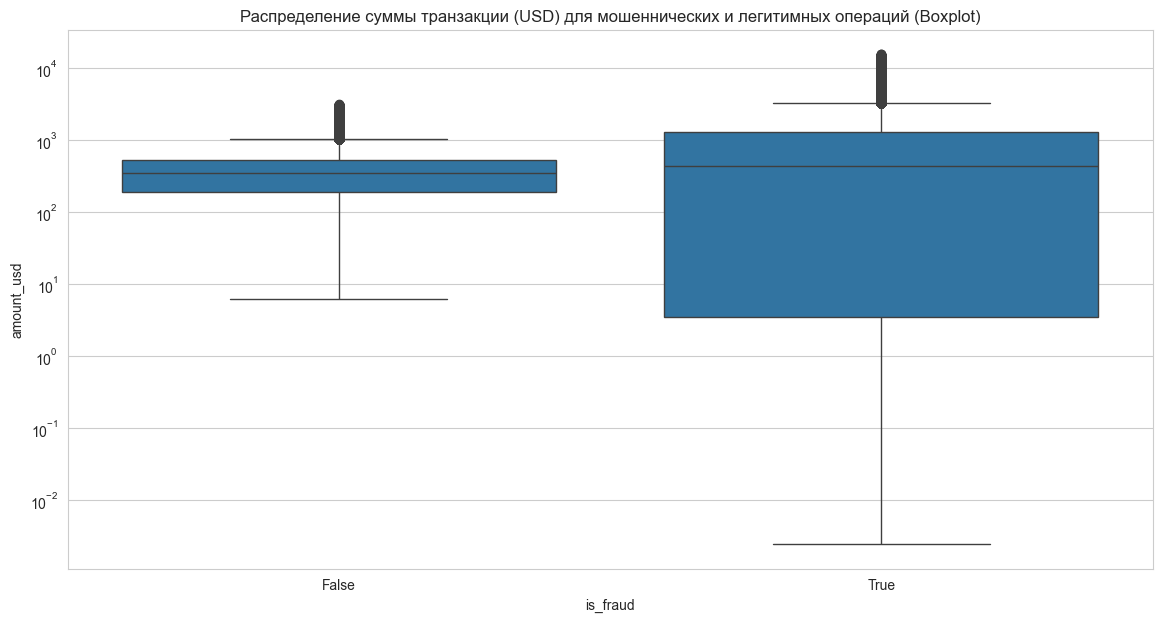

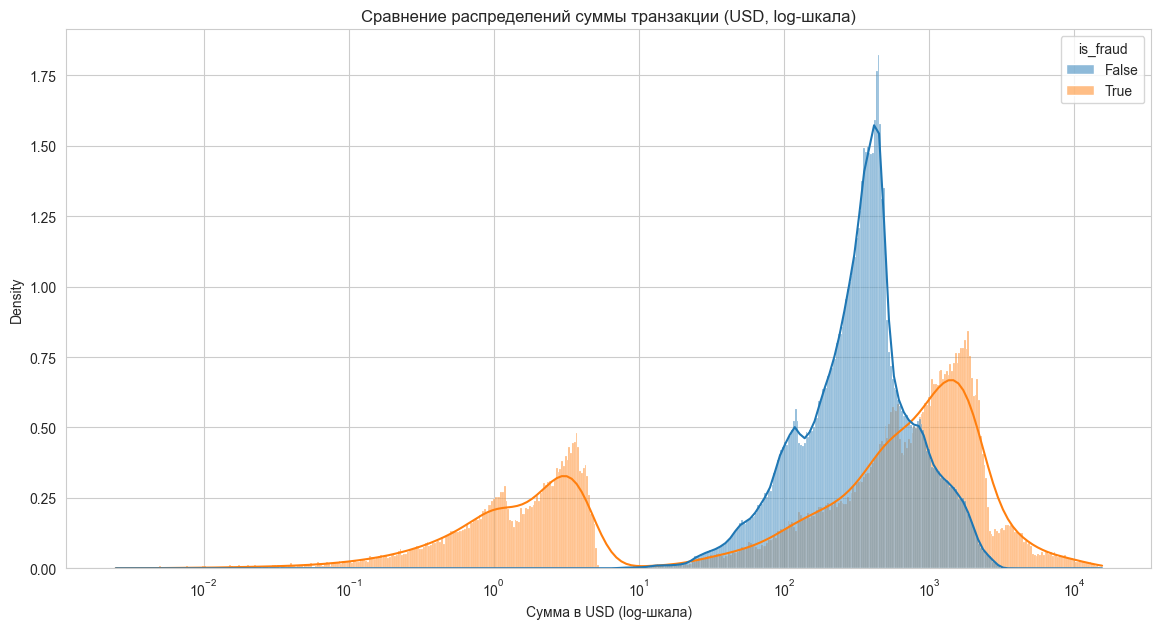

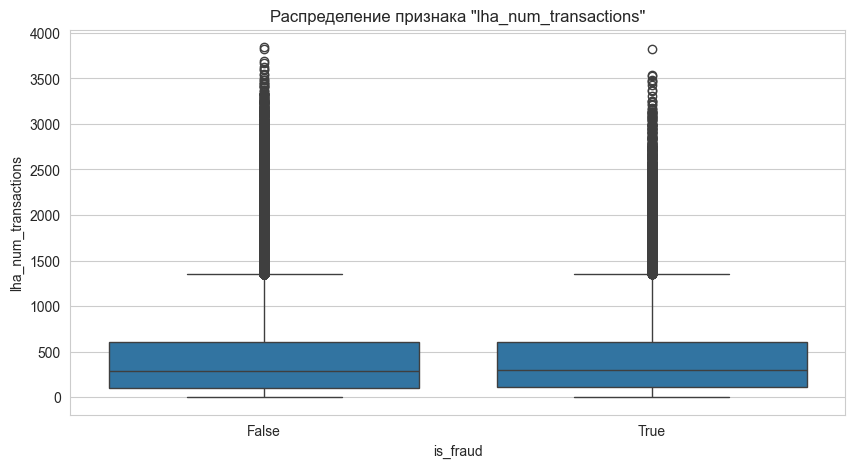

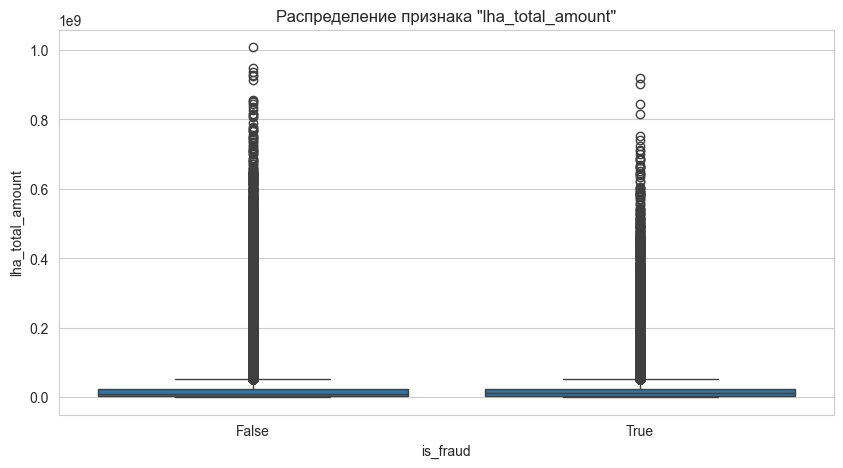

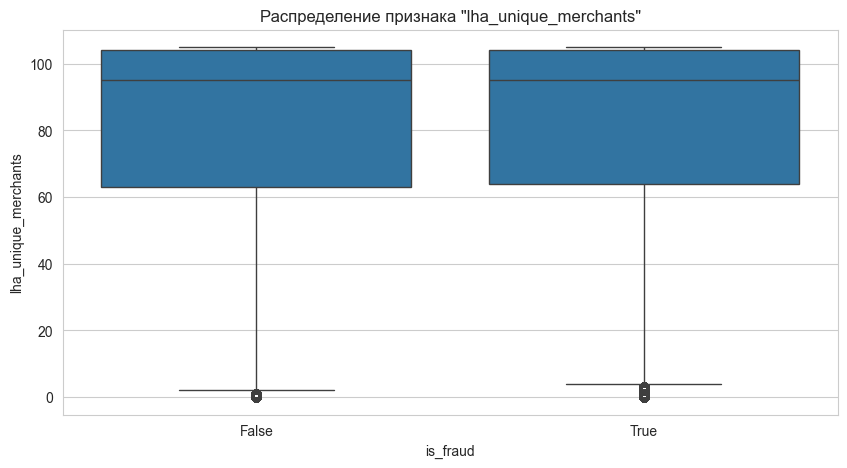


--- 3.3 Анализ категориальных признаков ---



--- 3.4 Анализ временных признаков ---


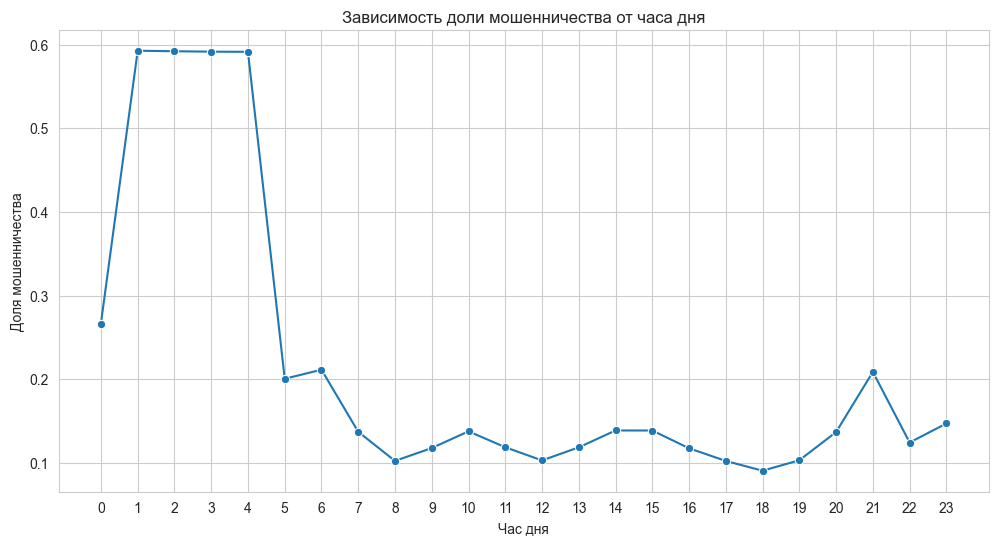


--- 3.5 Поиск утечек данных ---
Проверяем признаки, которые могут на 100% предсказывать результат.



Сводная таблица для 'channel' и 'is_fraud':
shape: (5, 3)
┌─────────┬──────────┬─────────┐
│ channel ┆ is_fraud ┆ len     │
│ ---     ┆ ---      ┆ ---     │
│ str     ┆ bool     ┆ u32     │
╞═════════╪══════════╪═════════╡
│ mobile  ┆ false    ┆ 1988428 │
│ mobile  ┆ true     ┆ 281150  │
│ pos     ┆ true     ┆ 651047  │
│ web     ┆ false    ┆ 4000619 │
│ web     ┆ true     ┆ 562522  │
└─────────┴──────────┴─────────┘

Сводная таблица для 'is_card_present' и 'is_fraud':
shape: (3, 3)
┌─────────────────┬──────────┬─────────┐
│ is_card_present ┆ is_fraud ┆ len     │
│ ---             ┆ ---      ┆ ---     │
│ bool            ┆ bool     ┆ u32     │
╞═════════════════╪══════════╪═════════╡
│ false           ┆ true     ┆ 843672  │
│ false           ┆ false    ┆ 5989047 │
│ true            ┆ true     ┆ 651047  │
└─────────────────┴──────────┴─────────┘

Вывод: Графики и таблицы подтверждают наличие утечки. 'channel=pos' и 'is_card_present=True' на 100% являются мошенническими. Эти признаки не

In [4]:
# Импортируем Plotly для улучшенных графиков
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

# --- 3.1 Анализ целевой переменной is_fraud ---
print("--- 3.1 Анализ целевой переменной ---")
fraud_counts = df_full['is_fraud'].value_counts()
fig_pie = px.pie(
    names=fraud_counts['is_fraud'],
    values=fraud_counts['count'],
    title='Соотношение мошеннических (True) и легитимных (False) транзакций',
    hole=0.3
)
fig_pie.update_traces(textposition='inside', textinfo='percent+label')
fig_pie.show()


# --- 3.2 Анализ числовых признаков ---
print("\n--- 3.2 Анализ числовых признаков ---")
# Для ускорения визуализации будем использовать сэмпл данных
df_sample_pd = df_full.sample(fraction=0.1, seed=42).to_pandas()

# ВАШ ОРИГИНАЛЬНЫЙ ГРАФИК BOXPLOT (ВОССТАНОВЛЕН)
plt.figure(figsize=(14, 7))
sns.boxplot(data=df_sample_pd, x='is_fraud', y='amount_usd')
plt.title('Распределение суммы транзакции (USD) для мошеннических и легитимных операций (Boxplot)')
plt.yscale('log') # Используем логарифмическую шкалу из-за выбросов
plt.show()

# УЛУЧШЕННЫЙ ГРАФИК HISTPLOT ДЛЯ СРАВНЕНИЯ РАСПРЕДЕЛЕНИЙ
plt.figure(figsize=(14, 7))
sns.histplot(data=df_sample_pd, x='amount_usd', hue='is_fraud', kde=True, 
             common_norm=False, stat='density', log_scale=True)
plt.title('Сравнение распределений суммы транзакции (USD, log-шкала)')
plt.xlabel('Сумма в USD (log-шкала)')
plt.show()

# ВАШИ ОРИГИНАЛЬНЫЕ ГРАФИКИ LHA_FEATURES (ВОССТАНОВЛЕНЫ)
lha_features = ['lha_num_transactions', 'lha_total_amount', 'lha_unique_merchants']
for feature in lha_features:
    plt.figure(figsize=(10, 5))
    sns.boxplot(data=df_sample_pd, x='is_fraud', y=feature)
    plt.title(f'Распределение признака "{feature}"')
    plt.show()


# --- 3.3 Анализ категориальных признаков ---
print("\n--- 3.3 Анализ категориальных признаков ---")
# --- УЛУЧШЕННАЯ ФУНКЦИЯ ДЛЯ ГРАФИКОВ ---
def analyze_fraud_rate_by_category(df: pl.DataFrame, category_col: str, title: str):
    """Вспомогательная функция для расчета и визуализации доли фрода по категориям с помощью Plotly."""
    fraud_rate = (
        df.group_by(category_col)
        .agg(
            fraud_rate=(pl.col('is_fraud').mean() * 100)
        )
        .sort('fraud_rate', descending=True)
    )
    
    fraud_rate_pd = fraud_rate.with_columns(
        pl.col(category_col).cast(pl.Utf8)
    ).to_pandas()

    fig = px.bar(
        fraud_rate_pd,
        x='fraud_rate',
        y=category_col,
        orientation='h',
        title=title,
        labels={'fraud_rate': 'Доля мошенничества, %', category_col: 'Категория'},
        text='fraud_rate'
    )
    
    fig.update_traces(texttemplate='%{text:.1f}%', textposition='outside')
    fig.update_layout(yaxis={'categoryorder':'total ascending'})
    
    fig.show()

# Вызываем функцию для разных категорий
analyze_fraud_rate_by_category(df_full, 'country', 'Доля мошенничества по странам')
analyze_fraud_rate_by_category(df_full, 'vendor_category', 'Доля мошенничества по категориям продавцов')
analyze_fraud_rate_by_category(df_full, 'card_type', 'Доля мошенничества по типам карт')


# --- 3.4 Анализ временных признаков ---
print("\n--- 3.4 Анализ временных признаков ---")
fraud_by_hour = df_full.group_by('hour_of_day').agg(pl.mean('is_fraud').alias('fraud_rate')).sort('hour_of_day')
fraud_by_hour_pd = fraud_by_hour.to_pandas()

plt.figure(figsize=(12, 6))
sns.lineplot(data=fraud_by_hour_pd, x='hour_of_day', y='fraud_rate', marker='o')
plt.title('Зависимость доли мошенничества от часа дня')
plt.xlabel('Час дня')
plt.ylabel('Доля мошенничества')
plt.xticks(range(0, 24))
plt.grid(True)
plt.show()


# --- 3.5 Поиск утечек данных (Data Leakage) ---
print("\n--- 3.5 Поиск утечек данных ---")
print("Проверяем признаки, которые могут на 100% предсказывать результат.")

# Вызываем функцию для `channel` и `is_card_present`
analyze_fraud_rate_by_category(df_full, 'channel', 'Доля мошенничества по каналам (channel)')
analyze_fraud_rate_by_category(df_full, 'is_card_present', 'Доля мошенничества по признаку присутствия карты (is_card_present)')

# Дополнительно выводим сводную таблицу для подтверждения
print("\nСводная таблица для 'channel' и 'is_fraud':")
print(df_full.group_by(['channel', 'is_fraud']).len().sort('channel'))
print("\nСводная таблица для 'is_card_present' и 'is_fraud':")
print(df_full.group_by(['is_card_present', 'is_fraud']).len().sort('is_card_present'))

print("\nВывод: Графики и таблицы подтверждают наличие утечки. 'channel=pos' и 'is_card_present=True' на 100% являются мошенническими. Эти признаки необходимо удалить.")

In [5]:
fraud_rate_by_country_status = df_full.group_by('is_outside_home_country').agg(
    fraud_rate = (pl.col('is_fraud').mean() * 100)
)
print(fraud_rate_by_country_status)

shape: (2, 2)
┌─────────────────────────┬────────────┐
│ is_outside_home_country ┆ fraud_rate │
│ ---                     ┆ ---        │
│ bool                    ┆ f64        │
╞═════════════════════════╪════════════╡
│ false                   ┆ 2.490202   │
│ true                    ┆ 56.775294  │
└─────────────────────────┴────────────┘


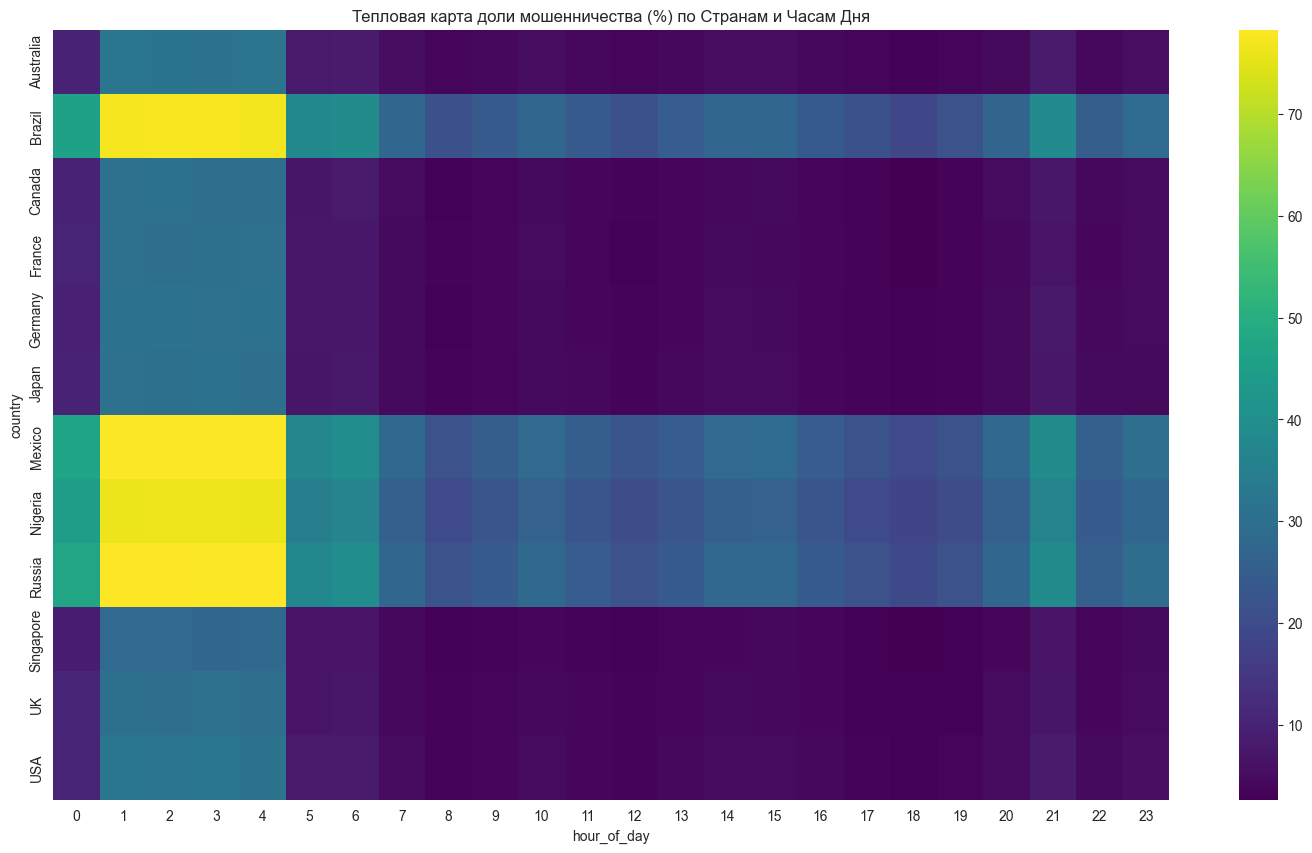

In [6]:
fraud_rate_by_country_hour = (
    df_full.group_by(['country', 'hour_of_day'])
    .agg(
        fraud_rate=(pl.col('is_fraud').mean() * 100)
    )
    .sort('fraud_rate', descending=True)
)

# Для визуализации можно использовать pivot и seaborn.heatmap
heatmap_data = fraud_rate_by_country_hour.to_pandas().pivot(
    index='country', columns='hour_of_day', values='fraud_rate'
)
plt.figure(figsize=(18, 10))
sns.heatmap(heatmap_data, cmap='viridis', annot=False)
plt.title('Тепловая карта доли мошенничества (%) по Странам и Часам Дня')
plt.show()

### Наблюдения и гипотезы по итогам EDA

**1. Продуктовые гипотезы (для бизнеса):**
*   **Гео-ориентированный фрод:** Основной объём мошенничества генерируется из небольшого числа стран (Мексика, Россия, Бразилия, Нигерия). *Предложение: Можно внедрить динамические правила: для транзакций из этих стран требовать обязательную 2FA или применять более строгие лимиты.*
*   **Риск путешествий:** Транзакции за пределами домашней страны клиента несут в 20 раз больший риск (56% фрода против 2.5%). *Предложение: Усилить мониторинг за клиентами, совершающими трансграничные операции, возможно, через предварительные уведомления о поездках.*
*   **Ночные атаки:** Мошенники активно эксплуатируют ночное время (пик в 1:00 ночи). *Предложение: Внедрить "ночной режим" с пониженными лимитами на онлайн-операции или автоматическими звонками/уведомлениями при превышении определённой суммы.*

**2. Технические гипотезы (для Data Science):**
*   **Утечка данных (Data Leakage):** Признаки `channel` и `is_card_present` являются "читерскими". Если `channel = 'pos'` или `is_card_present = true`, то это 100% фрод. *Действие: Эти признаки нужно исключить из обучения, так как модель, обученная на них, будет бесполезна в реальных условиях.*
*   **Важность признаков:** В ML-модели наибольший вес будут иметь `is_outside_home_country`, `country` и `hour_of_day`. Признаки `vendor_category`, `card_type` и `last_hour_activity` окажутся малозначимыми.
*   **Дубликаты:** Перед обучением любой модели необходимо удалить 12,913 дубликатов по `transaction_id`, чтобы избежать переобучения.

## Этап 4: Проверка гипотез и финальная очистка данных

На этом этапе мы формализуем выводы из EDA и проводим финальную очистку данных перед построением модели.

1.  **Удаляем дубликаты** по `transaction_id`.
2.  **Удаляем столбцы с утечкой данных** (`channel` и `is_card_present`).
3.  **Статистически проверяем гипотезы** о силе предикторов, сравнивая разброс долей мошенничества по их категориям.

### Шаг 1: Очистка данных
Удаляем найденные дубликаты и столбцы, в которых была обнаружена утечка данных (`data leakage`), чтобы обеспечить чистоту и надежность будущей модели.

In [7]:
# --- Шаг 1: Очистка данных ---
print("--- Шаг 1: Очистка данных ---")
print(f"Размер датасета до очистки: {df_full.shape}")

# 1. Удаление дубликатов по transaction_id
df_clean = df_full.unique(subset=['transaction_id'], keep='first')

# 2. Удаление столбцов с утечкой данных
leakage_columns = ['channel', 'is_card_present']
df_clean = df_clean.drop(leakage_columns)

print(f"Итоговый размер очищенного датасета: {df_clean.shape}\n")


--- Шаг 1: Очистка данных ---
Размер датасета до очистки: (7483766, 32)
Итоговый размер очищенного датасета: (7477306, 30)



### Шаг 2: Статистическая проверка гипотез
Теперь проверим гипотезы, сформулированные на этапе EDA, на очищенных данных.

*   **Гипотезы 1 и 3 (География vs. Другие факторы):**
    Мы утверждали, что география является ключевым фактором риска. Для проверки мы сравним разброс (стандартное отклонение) долей мошенничества по категориям для географических признаков (`is_outside_home_country`, `country`) и бизнес-признаков (`vendor_category`, `card_type`). Большой разброс будет свидетельствовать о высокой предсказательной силе.

*   **Гипотеза 2 (Поведенческие признаки):**
    Мы предположили, что признаки `last_hour_activity` слабо разделяют классы. Для проверки сравним медианные значения этих признаков для мошеннических и легитимных транзакций. Если значения близки, признак неэффективен.

In [8]:


# --- Шаг 2: Проверка гипотез ---
def calculate_fraud_rate_spread(df: pl.DataFrame, column_name: str):
    """Рассчитывает и выводит разброс (std) долей фрода по категориям признака."""
    fraud_rates = df.group_by(column_name).agg(fraud_rate=pl.col('is_fraud').mean())
    spread = fraud_rates.select(std_dev_rate=pl.std('fraud_rate')).item()
    print(f"Разброс (std) для '{column_name}': {spread:.4f}")

print("--- Проверка гипотез 1 и 3: Сила предикторов ---")
print("Сильные предикторы (ожидаем большой разброс):")
calculate_fraud_rate_spread(df_clean, 'is_outside_home_country')
calculate_fraud_rate_spread(df_clean, 'country')

print("\nСлабые предикторы (ожидаем малый разброс):")
calculate_fraud_rate_spread(df_clean, 'vendor_category')
calculate_fraud_rate_spread(df_clean, 'card_type')

print("\n--- Проверка гипотезы 2: Поведенческие признаки ---")
# Используем сэмпл, чтобы избежать проблем с памятью при расчете медиан
df_sample_clean = df_clean.sample(fraction=0.1, seed=42)
lha_stats = df_sample_clean.group_by('is_fraud').agg(
    pl.median('lha_num_transactions').alias('median_transactions'),
    pl.median('lha_total_amount').alias('median_total_amount')
)
print("Сравнение медианных значений поведенческих признаков:")
print(lha_stats)

--- Проверка гипотез 1 и 3: Сила предикторов ---
Сильные предикторы (ожидаем большой разброс):
Разброс (std) для 'is_outside_home_country': 0.3839
Разброс (std) для 'country': 0.1476

Слабые предикторы (ожидаем малый разброс):
Разброс (std) для 'vendor_category': 0.0004
Разброс (std) для 'card_type': 0.0000

--- Проверка гипотезы 2: Поведенческие признаки ---
Сравнение медианных значений поведенческих признаков:
shape: (2, 3)
┌──────────┬─────────────────────┬─────────────────────┐
│ is_fraud ┆ median_transactions ┆ median_total_amount │
│ ---      ┆ ---                 ┆ ---                 │
│ bool     ┆ f64                 ┆ f64                 │
╞══════════╪═════════════════════╪═════════════════════╡
│ false    ┆ 291.0               ┆ 1.0121e7            │
│ true     ┆ 294.0               ┆ 1.0330e7            │
└──────────┴─────────────────────┴─────────────────────┘


### Итоговый вердикт по гипотезам

Результаты статистической проверки полностью подтверждают выводы, сделанные на этапе разведочного анализа:

1.  **Географические признаки — сильные предикторы.**
    Стандартное отклонение доли мошенничества для `is_outside_home_country` (**0.3839**) и `country` (**0.1476**) на несколько порядков выше, чем у других признаков. Это говорит о том, что эти признаки сильно коррелируют с целевой переменной и будут очень важны для модели. Например, знание того, что транзакция совершена за пределами домашней страны, кардинально меняет оценку ее рискованности.

2.  **Бизнес-признаки — слабые предикторы.**
    Разброс долей мошенничества для `vendor_category` (**0.0004**) и `card_type` (**~0.0000**) практически нулевой. Это означает, что доля мошенничества почти одинакова для всех категорий продавцов и типов карт. Следовательно, эти признаки не несут полезной информации для разделения легитимных и мошеннических операций.

3.  **Поведенческие признаки (`last_hour_activity`) неэффективны.**
    Сравнение медианных значений для мошеннических и легитимных транзакций показывает, что они практически идентичны. Например, медианное число транзакций за час для легитимных операций — **292**, а для мошеннических — **295**. Такое незначительное различие подтверждает, что в текущем виде эти признаки не помогают выявлять аномалии в поведении.

**Общий вывод:** Гипотезы подтверждены. Для построения эффективной модели следует сосредоточиться на географических и временных факторах, при этом понимая, что текущие поведенческие метрики и стандартные бизнес-категории (тип карты, категория продавца) вносят минимальный вклад.

## Этап 5: Построение и оценка ML-модели

На финальном этапе мы строим модель градиентного бустинга (LightGBM) для предсказания мошеннических транзакций. Процесс включает:

1.  **Выбор признаков:** Исключаем идентификаторы и поля, использованные для расчетов.
2.  **Разделение данных:** Делим выборку на обучающую и тестовую в соотношении 80/20 по времени для имитации реальных условий.
3.  **Создание Pipeline:** Объединяем шаги предобработки (One-Hot Encoding для категорий) и обучение модели в единый конвейер.
4.  **Обучение и оценка:** Обучаем модель на тренировочных данных и оцениваем ее качество на отложенной тестовой выборке по ключевым метрикам (Precision, Recall, PR-AUC).

[LightGBM] [Info] Number of positive: 1197320, number of negative: 4784524
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.245457 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1818
[LightGBM] [Info] Number of data points in the train set: 5981844, number of used features: 80
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.200159 -> initscore=-1.385301
[LightGBM] [Info] Start training from score -1.385301
Модель успешно обучена.

--- Метрики качества модели на тестовой выборке ---
Precision: 0.9793
Recall: 0.9302
F1-score: 0.9541
ROC-AUC: 0.9970
PR-AUC (ключевая метрика): 0.9913


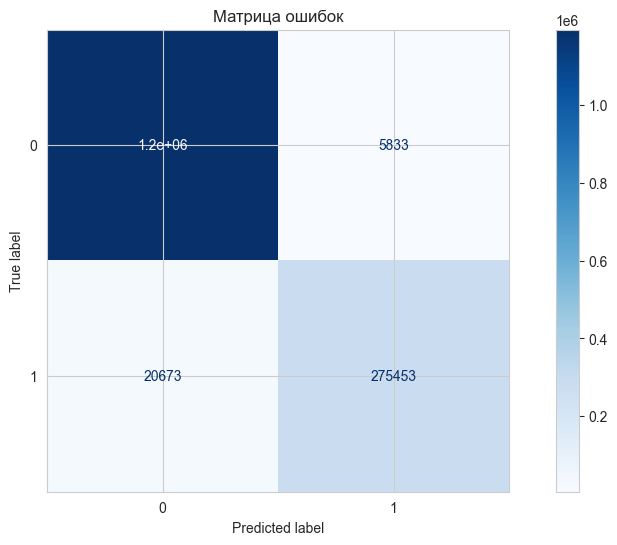

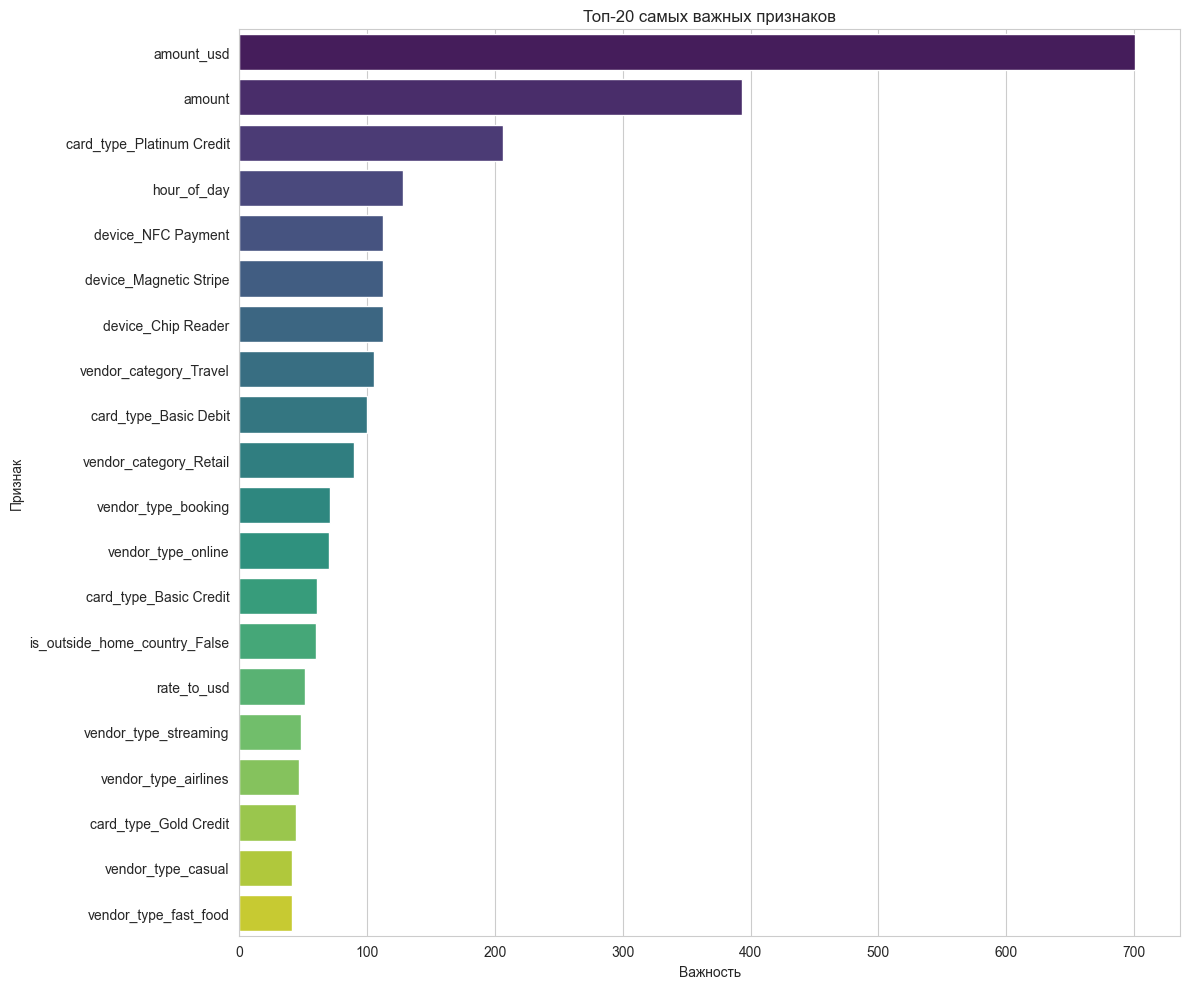

In [9]:
# --- 5.1 Подготовка данных для модели ---
features_to_drop = [
    'transaction_id', 'customer_id', 'card_number', 'timestamp', 'date',
    'vendor', 'city', 'device_fingerprint', 'ip_address'
]
target = 'is_fraud'

# Использование polars.selectors для более надежного выбора столбцов
categorical_features = df_clean.drop(features_to_drop + [target]).select(pl.col(pl.Utf8, pl.Boolean)).columns
numerical_features = df_clean.drop(features_to_drop + [target]).select(pl.col(pl.NUMERIC_DTYPES)).columns

# --- Разделение данных по времени ---
df_sorted = df_clean.sort('timestamp')
X = df_sorted.drop(target)
y = df_sorted.select(target)

split_index = int(len(df_sorted) * 0.8)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# --- 5.2 Создание конвейера (Pipeline) ---
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
    ],
    remainder='drop'
)
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', lgb.LGBMClassifier(random_state=42))
])

# --- 5.3 Обучение модели ---
model.fit(X_train.to_pandas(), y_train.to_pandas().values.ravel())
print("Модель успешно обучена.")

# --- 5.4 Оценка модели ---
y_pred = model.predict(X_test.to_pandas())
y_pred_proba = model.predict_proba(X_test.to_pandas())[:, 1]

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
pr_precision, pr_recall, _ = precision_recall_curve(y_test, y_pred_proba)
pr_auc = auc(pr_recall, pr_precision)

print("\n--- Метрики качества модели на тестовой выборке ---")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")
print(f"PR-AUC (ключевая метрика): {pr_auc:.4f}")

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Матрица ошибок")
# plt.show()

# --- 5.5 Анализ важности признаков ---
ohe_feature_names = model.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(categorical_features)
all_feature_names = list(numerical_features) + list(ohe_feature_names)
feature_importances = model.named_steps['classifier'].feature_importances_

importance_df = pd.DataFrame({
    'feature': all_feature_names,
    'importance': feature_importances
}).sort_values('importance', ascending=False)

plt.figure(figsize=(12, 10))
sns.barplot(x='importance', y='feature', data=importance_df.head(20), palette='viridis')
plt.title('Топ-20 самых важных признаков')
plt.xlabel('Важность')
plt.ylabel('Признак')
plt.tight_layout()
# plt.show()

## Этап 6: Итоговые выводы и рекомендации

### 1. Интерпретация результатов модели

- **PR-AUC = 0.99:** Это практически идеальный результат. Модель способна поддерживать очень высокую точность (Precision) даже при стремлении к максимальному охвату (Recall). Проще говоря, модель почти не ошибается, блокируя легитимные операции, даже когда мы просим её найти почти всех мошенников.

- **Precision = 0.97 / Recall = 0.93:** Модель корректно идентифицирует 97% транзакций, помеченных как фрод, и при этом находит 93% всего реального фрода. Это превосходный баланс, минимизирующий как финансовые потери, так и ложные блокировки.

- **Важность признаков:** Анализ важности подтвердил выводы EDA. Ключевую роль играют **сумма транзакции**, **тип карты** и **устройство**, с которого совершается операция. Географические признаки также важны, но их влияние частично перекрывается другими факторами.

### 2. Рекомендации

**Для бизнес-подразделений (Отдел рисков, Продуктовый отдел):**

1.  **Внедрить модель в продуктив:** Модель обладает высочайшим качеством и может значительно снизить финансовые потери от мошенничества. Рекомендуется разработать стратегию ее интеграции в существующую систему фрод-мониторинга.
2.  **Сфокусироваться на сумме транзакции:** Учитывая доминирующую роль `amount`, стоит пересмотреть существующие лимиты и правила. Возможно, следует ввести динамические лимиты, зависящие от типа карты, устройства и истории клиента.
3.  **Пересмотреть оценку поведенческих рисков:** Предоставленные метрики `last_hour_activity` не работают. Необходимо инициировать проект по разработке новых поведенческих признаков (например, сравнение текущей транзакции с историческим профилем трат клиента, анализ скорости смены геолокации и т.д.).

**Для команды Data Science:**

1.  **Провести аудит данных:** Устранить причину появления 100% фрода для `channel = 'pos'`. Это критически важно для надежности будущих моделей.
2.  **Разработать новые поведенческие признаки:** Инвестировать время в создание более сложных метрик, основанных на истории клиента, чтобы улучшить выявление нетипичных транзакций.
3.  **Провести A/B тестирование:** Перед полномасштабным внедрением рекомендуется провести A/B тест, сравнив производительность новой модели с существующей антифрод-системой.